In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

### **Init**

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [5]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [6]:
def print_example(idx, text, summ, bull):
    print(idx)
    print(fill(text, 150))
    print()
    print('Prediction:')
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Plot Evaluation

In [7]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Recurrent Decoder Summarization Function**

In [8]:
def recurrent_decoder_summarization(text, model_name_or_path):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    num_chunk = len(text)
    bullets_min_len_perchunk = int(config.BULLETS_MIN_LEN / num_chunk)
    bullets_max_len_perchunk = int(config.BULLETS_MAX_LEN / num_chunk)
    decoder_input_ids = None

    part_summ_min_len = bullets_min_len_perchunk
    part_summ_max_len = bullets_max_len_perchunk

    for chunk in text:
        if decoder_input_ids is not None:
            summ_enc = model.generate(
                tokenizer.encode(chunk, return_tensors='pt').to(device),
                min_length = part_summ_min_len,
                max_length = part_summ_max_len,
                decoder_input_ids = decoder_input_ids,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
        else:
            summ_enc = model.generate(
                tokenizer.encode(chunk, return_tensors='pt').to(device),
                min_length = part_summ_min_len,
                max_length = part_summ_max_len,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]

        summ = tokenizer.decode(
            summ_enc,
            skip_special_tokens=True)

        # removing "end of sentence" token
        decoder_input_ids = summ_enc.reshape((1, len(summ_enc)))[:, :-1]
        part_summ_min_len = len(decoder_input_ids[0]) + bullets_min_len_perchunk
        part_summ_max_len += bullets_max_len_perchunk

    return summ

## **Chunk Chapter**

In [9]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_chunk_chapter/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/recurrent_decoder_cc/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [10]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])\
    .groupby(level=[0, 1], sort=False).agg({'bullets': lambda b: list(b)[0], 'text': lambda t: list(t)})
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])\
    .groupby(level=[0, 1], sort=False).agg({'bullets': lambda b: list(b)[0], 'text': lambda t: list(t)})
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])\
    .groupby(level=[0, 1], sort=False).agg({'bullets': lambda b: list(b)[0], 'text': lambda t: list(t)})

### **Print**

##### Function

In [11]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)

    df_examples['summ'] =\
        df_examples.text.progress_map(lambda t: recurrent_decoder_summarization(t, model_name_or_path))

    for idx, row in df_examples.iterrows():
        print_example(idx, ' '.join(row.text), row.summ, row.bullets)

##### Print Train Examples

In [12]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[*] importing the model



  0%|          | 0/10 [00:00<?, ?it/s]

[+] the model is now present in cache



100%|██████████| 10/10 [04:39<00:00, 27.91s/it]

(9781908541963, 'chapter12')
Liver transplantation . About 6000 liver transplants are performed annually in both the USA and Europe . After transplant, most patients enjoy long-
term survival and dramatic improvements in quality of life . Many patients with advanced liver disease, however, are not candidates for liver
transplantation, in part due to the limited supply of donor organs . Referring physicians should understand the importance of timing the referral for
liver transplantation, be familiar with its indications and contraindications and be comfortable with a pretransplantation evaluation . Indications
and contraindications . Liver transplantation may be a viable option for patients with advanced liver disease of almost any etiology . In the USA, the
most common indications for transplantation resulting from chronic liver disease are viral hepatitis and alcoholic liver disease (ALD) (Table 12.1) .
Severe liver disease that has resulted from acute disorders may also require live

##### Print Val Examples

In [13]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

100%|██████████| 10/10 [05:18<00:00, 31.88s/it]

(9783318067095, 'ch8')
Measurement in clinical trials . The goal of any trial is to determine both the safety and efficacy of a new medical product . Measures within the
trial process must demonstrate the product's safety and efficacy to regulators before it is allowed to be labeled and marketed for use by patients .
However, measurement in clinical trials does not only inform regulatory decision-making . Early in the development of a new drug or novel medical
device, a company will make business decisions about whether to advance its new product for further testing . Early intelligence is extremely valuable
to biopharma companies, which face a US$2 million revenue opportunity per day the drug is on the market (or not) . Digital measures allow for the
collection of data outside of the clinic, providing a more continuous stream of data points on whether the drug or device is working or not .
Additionally, measurement data from clinical trials inform reimbursement decisions, which impact

##### Print Test Examples

In [14]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

100%|██████████| 10/10 [05:34<00:00, 33.48s/it]

(9781908541420, 'ch_6')
Successful asthma management will achieve both control of symptoms and prevention of acute attacks (Table 4.1) . To achieve this, preventive measures
including the use of medication to prevent symptoms to treat acute attacks is necessary . Avoidance of triggers where possible can also be important
(see allergen avoidance in Chapter 6) . Drugs used in the management of asthma can be classified as controllers (also called preventers) and relievers
. Controllers (preventers) are taken daily over the long term to control persistent asthma (Table 4.2) . They include anti-inflammatory agents such as
corticosteroids, sodium cromoglicate, nedocromil sodium and leukotriene modifiers, and long-acting bronchodilators such as long-acting beta -agonists
(LABAs), omalizumab and sustained-release theophylline . Inhaled corticosteroids, such as beclometasone (beclomethasone) dipropionate, budesonide,
fluticasone propionate, mometasone, fluticasone furoate and ciclesonide, are t

### **Summarization**

In [15]:
model_name_or_path = 'sshleifer/distilbart-cnn-12-6'

df_test['summary_'+model_name_or_path] =\
    df_test.text.progress_map(lambda t: recurrent_decoder_summarization(t, model_name_or_path))

100%|██████████| 43/43 [19:16<00:00, 26.90s/it]


### **Evaluation**

In [16]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [24]:
def evaluate_model(df, model_name_or_path):
    df_eval = df.groupby(['book', 'chapter'], sort=False).agg({
        'bullets': lambda b: ' '.join(list(b)),
        'summary_'+model_name_or_path: lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df_eval

In [25]:
evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

,,bullets,summary_sshleifer/distilbart-cnn-12-6,rouge1_precision_sshleifer/distilbart-cnn-12-6,rouge1_recall_sshleifer/distilbart-cnn-12-6,rouge1_fmeasure_sshleifer/distilbart-cnn-12-6,rouge2_precision_sshleifer/distilbart-cnn-12-6,rouge2_recall_sshleifer/distilbart-cnn-12-6,rouge2_fmeasure_sshleifer/distilbart-cnn-12-6,rougeL_precision_sshleifer/distilbart-cnn-12-6,rougeL_recall_sshleifer/distilbart-cnn-12-6,rougeL_fmeasure_sshleifer/distilbart-cnn-12-6
book,chapter,,,,,,,,,,,
9781908541277,ch_12,Depression and anxiety are common in patients ...,Depression is the most prevalent psychiatric ...,0.492958,0.234899,0.318182,0.185714,0.087838,0.119266,0.323944,0.154362,0.209091
9781910797907,chp6,The burden of transfusions in pyruvate kinase ...,The main focus of care for pyruvate kinase (P...,0.563636,0.473282,0.514523,0.247706,0.207692,0.225941,0.318182,0.267176,0.290456
9781908541277,ch_8,Sixteen new antiepileptic drugs (AEDs) have be...,Carbamazepine (CBZ) was synthesized by Schind...,0.103175,0.250000,0.146067,0.000000,0.000000,0.000000,0.079365,0.192308,0.112360
9781910797006,ch08,Acute exacerbations of COPD are common and pla...,In an average UK Health Authority with a popu...,0.254098,0.348315,0.293839,0.057851,0.079545,0.066986,0.139344,0.191011,0.161137
9781910797105,ch06,People with schizophrenia exhibit gray matter ...,Our knowledge of the neuroanatomy of schizoph...,0.410959,0.291262,0.340909,0.166667,0.117647,0.137931,0.232877,0.165049,0.193182
9783318068207,hh-5,Comprehensive genomic profiles offer a complet...,The adoption of broad NGS gene panels may sup...,0.473214,0.434426,0.452991,0.180180,0.165289,0.172414,0.241071,0.221311,0.230769
9781910797105,ch04,Having a close relative with schizophrenia inc...,The biggest single clue we have about the cau...,0.275510,0.380282,0.319527,0.061856,0.085714,0.071856,0.122449,0.169014,0.142012
9781910797006,ch03,"COPD occurs, though less commonly, in those wh...",The characteristic symptom of COPD is breathl...,0.504762,0.306358,0.381295,0.211538,0.127907,0.159420,0.323810,0.196532,0.244604
9781908541406,ch_6,Thrombocytopenia may occur with some inherited...,Some congenital platelet disorders are also a...,0.351852,0.339286,0.345455,0.065421,0.063063,0.064220,0.185185,0.178571,0.181818


##### Plot Evaluation

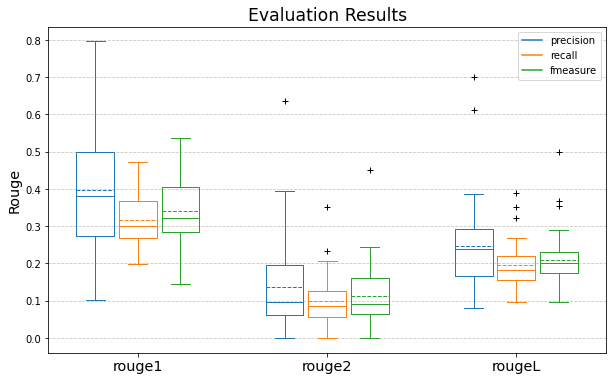

In [26]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')